# Appendix A: Tuning BM25 parameters for the MSMARCO Document dataset

The following shows a principled, data-driven approach to tuning BM25 parameters with a basic query, using the MSMARCO Document dataset. This assumes familiarity with basic query tuning as shown in the "Query tuning" notebooks.

BM25 contains two parameters `k1` and `b`. Roughly speaking (very roughly), `k1` controls the amount of term saturation (at some point, more terms does not mean more relevant) and `b` controls the importance of document length. A deeper look into these parameters is beyond the scope of this notebook, but our [three part blog series on understanding BM25](https://www.elastic.co/blog/practical-bm25-part-1-how-shards-affect-relevance-scoring-in-elasticsearch) is very useful for that.

Be aware that not all query types will see improvements with BM25 tuning. Sometimes it's more impactful to just tune query parameters. As always you try it out with your datasets first and get concrete measurements. We recommend customizing index settings/analyzers first, then do query parmeter tuning and get your baseline measurements. Next, try the best index settings/analyzers with BM25 tuning, then do query parameter tuning and see if it makes any improvement on your baseline. If there's no significant difference it's best to just stick with the default BM25 parameters for simplicty.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
import os
import sys

from elasticsearch import Elasticsearch
from skopt.plots import plot_objective

In [3]:
# project library
sys.path.insert(0, os.path.abspath('..'))

import qopt
importlib.reload(qopt)

from qopt.notebooks import evaluate_mrr100_dev, optimize_bm25_mrr100
from qopt.optimize import Config, set_bm25_parameters

In [4]:
# use a local Elasticsearch or Cloud instance (https://cloud.elastic.co/)
es = Elasticsearch('http://localhost:9200')

# set the parallelization parameter `max_concurrent_searches` for the Rank Evaluation API calls
max_concurrent_searches = 10

index = 'msmarco-document'
index_defaults = 'msmarco-document.defaults'
template_id = 'combined_matches'

# no query params
query_params = {}

# default Elasticsearch BM25 params
default_bm25_params = {'k1': 1.2, 'b': 0.75}

## Baseline evaluation

For tuning the BM25 parameters, we're going to use just a `match` query per field, combined using a `bool` `should` query. This will search for query terms across the `url`, `title`, and `body` fields, and we'll be attempting to optimize the BM25 parameters that are used in the scoring function for each field. In theory, each field could have it's own BM25 [similarty](https://www.elastic.co/guide/en/elasticsearch/reference/current/index-modules-similarity.html#bm25) and parameters, but we'll leave that as an exercise to the reader.

Since BM25 parameters are actually index settings in Elasticsearch (they are theoretically query parameters, but they are implemented as index settings to be consistent with other similarity modules), we need to make sure to set the parameters before any evaluation step. At optimization time, we'lll do the same process: set the BM25 parameters to try, then run the rank evaluation API on the training query dataset.

In [5]:
%%time

set_bm25_parameters(es, index, **default_bm25_params)

_ = evaluate_mrr100_dev(es, max_concurrent_searches, index, template_id, query_params)

Evaluation with: MRR@100
Score: 0.2504
CPU times: user 1.8 s, sys: 436 ms, total: 2.23 s
Wall time: 57.4 s


That's the same baseline that we've seen in the "Query tuning" notebook, so we know we're setup correctly.

## Optimization

Now we're ready to run the optimization procedure and see if we can improve on that, while holding the default query parameters constant.

We know that there's [roughly a standard range](https://www.elastic.co/blog/practical-bm25-part-3-considerations-for-picking-b-and-k1-in-elasticsearch) for each parameter, so we use those. We also set internally before running the optimization some static initial points to try, based on some well-known default parameter values:

  * Elasticsearch defaults: `k1`: `1.2`, `b`: `0.75`
  * Anserini [1] defaults: `k1`: `0.9`, `b`: `0.4`
  
[1] [anserini](https://github.com/castorini/anserini) is a commonly used tool in academia for research into search systems

In [6]:
%%time

_, best_params, _, metadata = optimize_bm25_mrr100(es, max_concurrent_searches, index, template_id, query_params,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 40,
        'num_initial_points': 20,
        'space': {
            'k1': { 'low': 0.5, 'high': 5.0 },
            'b': { 'low': 0.3, 'high': 1.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 - iteration 2 scored 0.2188 with: {'k1': 0.9, 'b': 0.4}
 - iteration 3 scored 0.2353 with: {'k1': 3.370604288950908, 'b': 0.6502501160664012}
 - iteration 4 scored 0.2350 with: {'k1': 4.019769356834095, 'b': 0.6559624038852268}
 - iteration 5 scored 0.2183 with: {'k1': 4.550172007175469, 'b': 0.36646469797122216}
 - iteration 6 scored 0.2197 with: {'k1': 4.510703804651055, 'b': 0.9990275259776924}
 - iteration 7 scored 0.2235 with: {'k1': 1.2557048044556212, 'b': 0.5681787231476463}
 - iteration 8 scored 0.2218 with: {'k1': 0.9492476027695534, 'b': 0.7428739712003931}
 - iteration 9 scored 0.2255 with: {'k1': 1.3366685724014589, 'b': 0.5938330471247484}
 - iteration 10 scored 0.2330 with: {'k1': 4.309783310447555, 'b': 0.7759034485189735}
 - iteration 11 scored 0.2195 with: {'k1': 1.5781739190991968, 'b': 0.3015016529905641}
 

Here's a look at the parameter space, which is easy to plot here since there are just two parameters. 

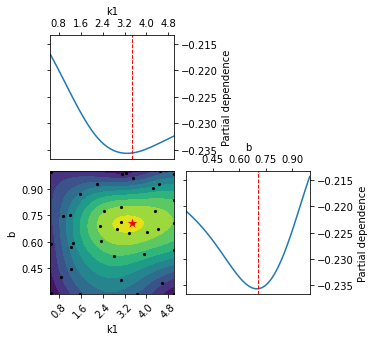

In [7]:
_ = plot_objective(metadata, sample_source='result')

In [8]:
%%time

set_bm25_parameters(es, index, **best_params)

_ = evaluate_mrr100_dev(es, max_concurrent_searches, index, template_id, query_params)

Evaluation with: MRR@100
Score: 0.2594
CPU times: user 1.92 s, sys: 534 ms, total: 2.45 s
Wall time: 34.2 s


Interesting that we do see an improvement but it's not very significant. One hypothesis is that maybe our analyzers are doing work that means there's not much left to tune. Let's try this again but using the default analyzers with the index `msmarco-document.defaults`.

First we set the baseline that we're comparing against. We expect it to be lower than the baseline with the custom analyzers. We saw this in the "Analyzers" notebook as well already.

In [9]:
%%time

set_bm25_parameters(es, index_defaults, **default_bm25_params)

_ = evaluate_mrr100_dev(es, max_concurrent_searches, index_defaults, template_id, query_params)

Evaluation with: MRR@100
Score: 0.2403
CPU times: user 2.19 s, sys: 687 ms, total: 2.88 s
Wall time: 4min 12s


Now let's optimize BM25. Before we do that, let's also increase the possible range of `k1` to make sure we really see a maximum score from somewhere within the range and not at a maximum or minumum value in the range.

In [10]:
%%time

_, best_params, _, metadata = optimize_bm25_mrr100(es, max_concurrent_searches, index_defaults, template_id, query_params,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 25,
        'space': {
            'k1': { 'low': 0.5, 'high': 10.0 },
            'b': { 'low': 0.3, 'high': 1.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 - iteration 2 scored 0.1971 with: {'k1': 0.9, 'b': 0.4}
 - iteration 3 scored 0.2322 with: {'k1': 9.366588476277936, 'b': 0.9122525300318791}
 - iteration 4 scored 0.2316 with: {'k1': 7.686680435518605, 'b': 0.965864493675082}
 - iteration 5 scored 0.2311 with: {'k1': 4.708495188944252, 'b': 0.9897547197883692}
 - iteration 6 scored 0.2193 with: {'k1': 2.2191277453389286, 'b': 0.5833472558883774}
 - iteration 7 scored 0.2075 with: {'k1': 1.8637850192899095, 'b': 0.33066321867136744}
 - iteration 8 scored 0.2162 with: {'k1': 8.500016824528396, 'b': 0.4732893649921234}
 - iteration 9 scored 0.2334 with: {'k1': 8.695331165873956, 'b': 0.777763765282391}
 - iteration 10 scored 0.2211 with: {'k1': 6.6069084823926785, 'b': 0.4931126256092313}
 - iteration 11 scored 0.2323 with: {'k1': 3.9716925801549317, 'b': 0.789458535906953}
 - i

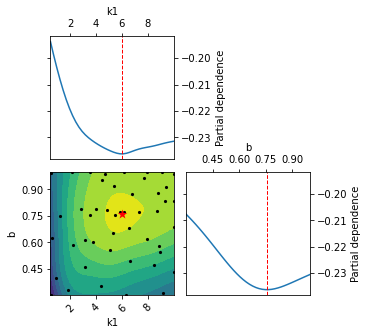

In [11]:
_ = plot_objective(metadata, sample_source='result')

In [12]:
%%time

set_bm25_parameters(es, index_defaults, **best_params)

_ = evaluate_mrr100_dev(es, max_concurrent_searches, index_defaults, template_id, query_params)

Evaluation with: MRR@100
Score: 0.2661
CPU times: user 2 s, sys: 651 ms, total: 2.65 s
Wall time: 1min 6s


That's a much larger improvement over the baseline, and actually this optimized version with the default analyzers beats the tuned version with the custom analyzers! Goes to show you that you can't make assumptions — you need to test your hypothesis!

## Conclusion

Before we wrap up, it's good to set all the indices back to their default values, in case we use those indices for other experiments.

In [13]:
set_bm25_parameters(es, index, **default_bm25_params)
set_bm25_parameters(es, index_defaults, **default_bm25_params)

We've shown a very simple but principled way to tune BM25 parameters `k1` and `b`. We've used a similar approach as when optimizing query parameters. In this case, it was useful to rely on Bayesian optimization since we set a pretty wide range over parameters. Stepping through each 1/10th or 1/100th of each parameter in a grid search would be very time consuming indeed.